This is a test for our project

In [63]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# # Specify the folder where your CSV files are located
# #folder_path = '/Users/joshmccoy/Desktop/NCAA_March_Madness/march-machine-learning-mania-2023/ImportantCSVs'
# folder_path = '/Users/jimhaines/Desktop/Extra\ 1/CAPSTONE/CapstoneProject/mens-march-mania-2022/MDataFiles_Stage1'

# # Initialize an empty dictionary to store DataFrames with their file names as keys
# dataframes = {}

# # Iterate through all files in the folder
# for filename in os.listdir(folder_path):
#     if filename.endswith(".csv"):
#         file_path = os.path.join(folder_path, filename)
#         try:
#             # Try different encodings until one works
#             df = pd.read_csv(file_path, encoding='utf-8')
#         except UnicodeDecodeError:
#             try:
#                 df = pd.read_csv(file_path, encoding='latin1')
#             except:
#                 df = pd.read_csv(file_path, encoding='ISO-8859-1')
        
#         # Use the file name (without the .csv extension) as the DataFrame's name/key
#         dataframe_name = os.path.splitext(filename)[0]
#         dataframes[dataframe_name] = df

# # Now, you have a dictionary where keys are the CSV file names (without .csv extension)
# # and values are the corresponding DataFrames for all CSV files in the folder.

In [64]:
# # Access the "MRegularSeasonDetailedResults" DataFrame from the dictionary
# m_regular_season_df = dataframes.get("MRegularSeasonDetailedResults")
# m_regular_season_df

# # Now, you have the "m_regular_season_df" DataFrame that corresponds to the "MRegularSeasonDetailedResults.csv" file

We can first look at how some basic factors affect the amount the winning team wins by. We want to look at the difference in score to see how dominant a team is against a competitor. A team who wins by a lot is typically a sign that this team is significantly better than its oponent.

In [65]:
# To do this we can look at regular season game stats
detailed_results_data = 'MRegularSeasonDetailedResults.csv'
detailed_results = pd.read_csv(detailed_results_data)
detailed_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100418,2022,98,1400,79,1242,76,H,0,28,67,...,13,15,23,5,24,10,15,3,5,21
100419,2022,98,1411,66,1126,63,A,0,24,59,...,21,15,24,5,23,10,19,13,2,23
100420,2022,98,1422,68,1441,49,A,0,23,56,...,24,8,11,10,18,5,16,8,2,12
100421,2022,98,1438,69,1181,68,A,0,31,65,...,17,18,22,11,25,14,14,3,9,11


In [66]:
# Create variable for amount by which winning team wins
detailed_results['SCOREDIFF'] = detailed_results['WScore'] - detailed_results['LScore']

In [67]:
# Winner stats
detailed_results.dtypes
detailed_results['WFGPCT'] = detailed_results['WFGM']/detailed_results['WFGA']       # field goal pt completion %
detailed_results['W3PCT'] = detailed_results['WFGM3']/detailed_results['WFGA3']      # 3 pt completion %
detailed_results['WFTPCT'] = detailed_results['WFTM']/detailed_results['WFTA']       # free throw completion %

detailed_results['WORBCHANCE'] =  detailed_results['WOR'] + detailed_results['LDR']  # total potential rebounds
detailed_results['WORPCT'] = detailed_results['WOR']/detailed_results['WORBCHANCE']  # rebound completion %

In [68]:
# Losing stats
detailed_results['LFGPCT'] = detailed_results['LFGM']/detailed_results['LFGA']       
detailed_results['L3PCT'] = detailed_results['LFGM3']/detailed_results['LFGA3']
detailed_results['LFTPCT'] = detailed_results['LFTM']/detailed_results['LFTA']

detailed_results['LORBCHANCE'] =  detailed_results['LOR'] + detailed_results['WDR']
detailed_results['LORPCT'] = detailed_results['LOR']/detailed_results['LORBCHANCE']

<AxesSubplot:>

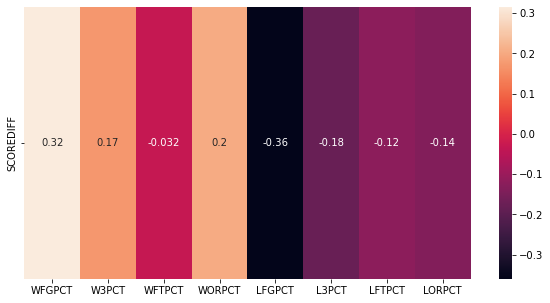

In [69]:
# Create correlation graph to see how each feature affects the winning score difference

plt.rc('figure', figsize=(10, 5))
tmp = detailed_results[(detailed_results['SCOREDIFF']>6)&(detailed_results['NumOT']==0)]
corr = tmp.corr()
corr = corr[corr.index.isin(['SCOREDIFF'])]
sns.heatmap(corr[['WFGPCT', 'W3PCT', 'WFTPCT', 'WORPCT', 'LFGPCT', 'L3PCT', 
                  'LFTPCT', 'LORPCT']], annot=True)



We can see that the winning teams field goal % correlates strongly with the winning score difference. This makes sense as basically, the higher your field goal %, the more likely you are to win. Contrastly, we can see that winners free throw % is not as important in predicting by how much a team will win. 

We can now take a more detailed look at the correlation between winner field goal % and score difference

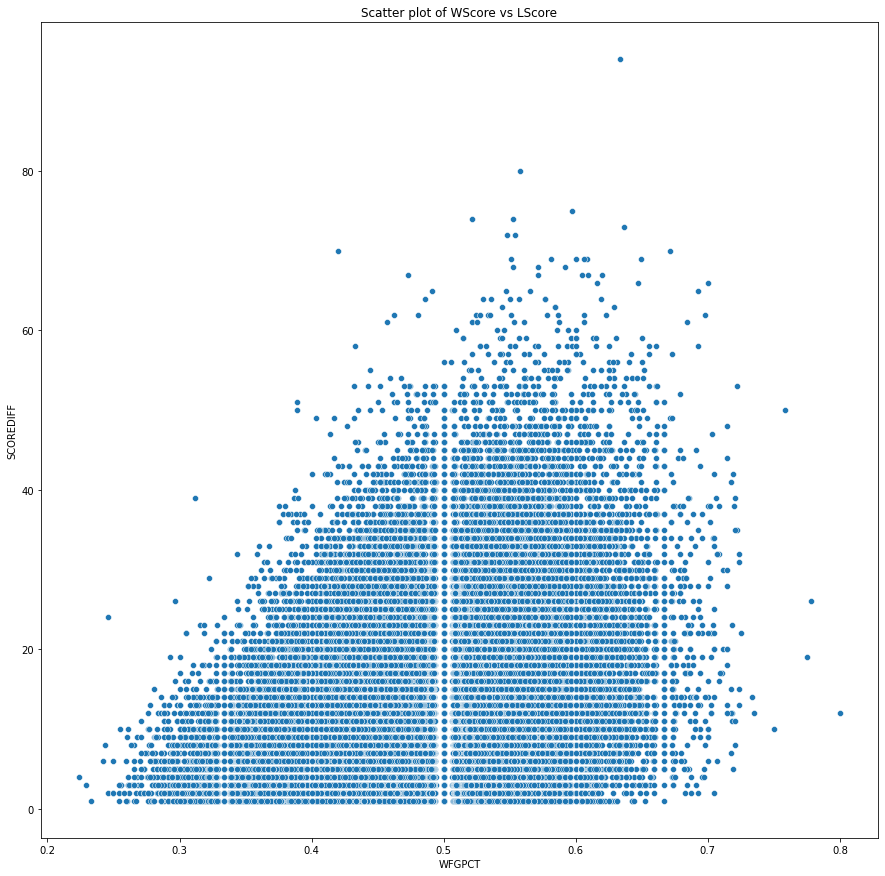

In [73]:
plt.figure(figsize=(15,15))
sns.scatterplot(x='WFGPCT', y='SCOREDIFF', data=detailed_results)
#sns.relplot(x = 'Height', y = 'Weight', data=df)

plt.title('Scatter plot of WScore vs LScore')
plt.xlabel('WFGPCT')
plt.ylabel('SCOREDIFF')
plt.show()

We can look at other factors as well:

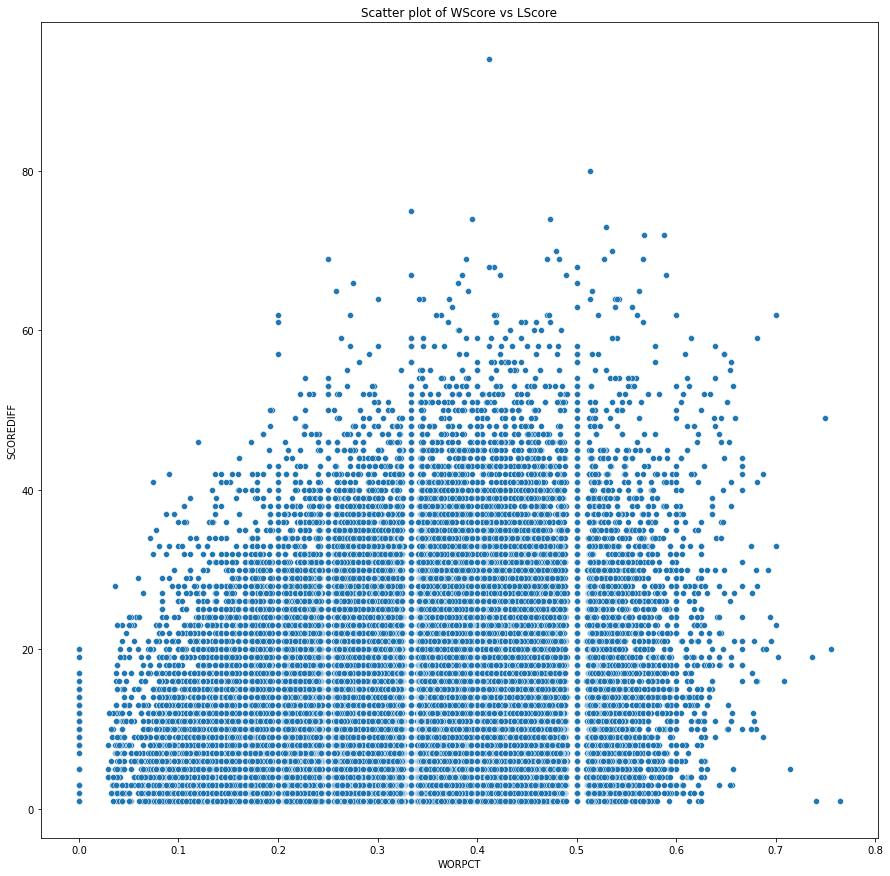

In [75]:
# detailed_tourney_data = 'MNCAATourneyDetailedResults.csv'
# detailed_tourney_results = pd.read_csv(detailed_tourney_data)

plt.figure(figsize=(15,15))
sns.scatterplot(x='WORPCT', y='SCOREDIFF', data=detailed_results)
#sns.relplot(x = 'Height', y = 'Weight', data=df)

plt.title('Scatter plot of WScore vs LScore')
plt.xlabel('WORPCT')
plt.ylabel('SCOREDIFF')
plt.show()

Despite the common phrase "board man gets paid", we can see that there is a less strong correlation between rebound % and score difference. Perhaps this saying holds more true a higher level of play.